## ЗАДАНИЕ 1
А/А-тест с '2024-01-19' по '2024-01-25'
Нужно сделать симуляцию, как будто мы провели 10000 А/А-тестов.
На каждой итерации нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.
1. Построить гистограмму распределения получившихся 10000 p-values.
2. Посчитать, какой процент p values оказался меньше либо равен 0.05
3. Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования.

In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline

In [2]:
connection = {'host': '*',
'database':'*',
'user':'*',
'password':'*'
}
ALFA = 0.05

In [40]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20240220.feed_actions 
WHERE toDate(time) between '2024-01-19' and '2024-01-25'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


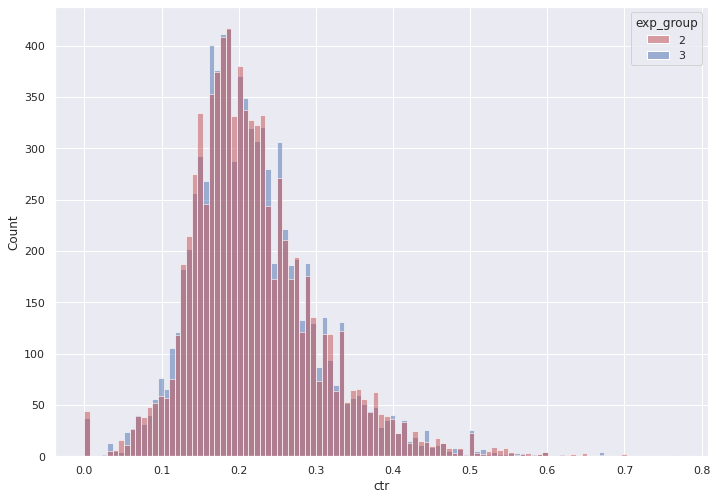

In [41]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

<h2>Постановка гипотез</h2>
<ul>
    <li> Нулевая гипотеза: средние CTR двух групп одинаковый. </li>
    <li> Альтернативная: средние CTR групп отличается.</li>
</ul>

In [52]:
_, p_value_tt = stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)
print(f'Т-тест {p_value_tt}. Отличие {"не " if p_value_tt > ALFA else ""}прокрасилось')

Т-тест 0.508153138292614. Отличие не прокрасилось


In [53]:
_, p_value_mw = stats.mannwhitneyu(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr)
print(f'Манн-Уитни {p_value_mw}. Отличие {"не " if p_value_mw > ALFA else ""}прокрасилось')

Манн-Уитни 0.8340910379715747. Отличие не прокрасилось


<Axes: ylabel='Count'>

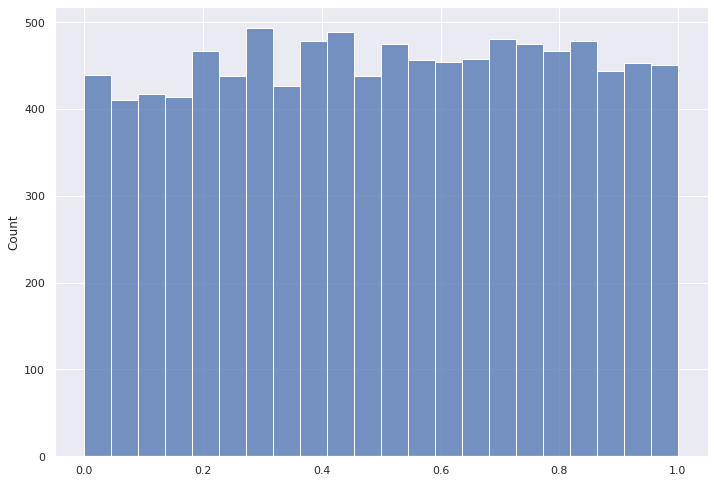

In [44]:
p_values = np.array([])
for _ in range(10000):
    sample_2 = df[df.exp_group == 2].ctr.sample(n = 500, replace = False).values
    sample_3 = df[df.exp_group == 3].ctr.sample(n = 500, replace = False).values
    _, pvalue = stats.ttest_ind(sample_2, sample_3, equal_var=False)
    p_values = np.append(p_values, pvalue)
sns.histplot(data = p_values)

In [45]:
percent = (np.sum(p_values <= ALFA) / len(p_values)) * 100
print(
    f'''В {percent}% случаев получаются статзначимые отличия. 
Что {"не " if percent < ALFA * 100 else ""}позволяет отклонить нулевую гипотезу'''
)

В 4.75% случаев получаются статзначимые отличия. 
Что не позволяет отклонить нулевую гипотезу


## Вывод.
<h4><p>A/A-тест не выявил ошибок в системе сплитования. 
Т-тест и Манн-Уитни по цельным группам не прокрасились. При имитации 10000 АА тестов процент p-value меньших или равных 0.05 составляет менее 5%. То же самое видно на гистограмме распределения p-values АА-тестов.</p>
<p>Нулевая гипотеза верна. Ч.т.д.</p></h4>